### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gzip
import json
import os
from urllib.request import urlopen

In [ ]:
np.random.seed(42)

In [3]:
path = 'Data/reviews_Home_and_Kitchen_5.json.gz'

In [4]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(path)

### DATA CLEANING / EDA

In [6]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"


In [7]:
df.shape

(551682, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551682 entries, 0 to 551681
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      551682 non-null  object 
 1   asin            551682 non-null  object 
 2   reviewerName    546729 non-null  object 
 3   helpful         551682 non-null  object 
 4   reviewText      551682 non-null  object 
 5   overall         551682 non-null  float64
 6   summary         551682 non-null  object 
 7   unixReviewTime  551682 non-null  int64  
 8   reviewTime      551682 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.1+ MB


In [9]:
df.drop(columns=['helpful']).duplicated().sum()

0

In [10]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      4953
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [11]:
# Converting 'unixReviewTime' column to a datetime type, and renaming column
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'], unit='s')

# Dropping 'unixReviewTime' and 'reviewTime' columns -- no longer necessary
df.drop(columns=['unixReviewTime', 'reviewTime'], inplace=True)

In [12]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,reviewDate
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,2013-10-19


##### Creating target ('ratio' >= 0.7) column 

In [13]:
# unpacking the list values in 'helpful' column into their own separate columns
helpfulness_df = pd.DataFrame(df['helpful'].tolist(), columns=['upvotes', 'total_votes'])

# adding new columns to dataframe
df = pd.concat([df, helpfulness_df], axis=1)

# fxn to get ratio of upvotes over total votes
def get_vote_ratio(row):
    try:
        return row['upvotes']/row['total_votes']
    except ZeroDivisionError:
        return 0

# creating new column with ratio values
df['ratio'] = df.apply(get_vote_ratio, axis=1)

# Setting classification threshold for 'helpful' at 70% of upvotes/total votes (1 = helpful, 0 = unhelpful)
df['target'] = (df['ratio'] >= 0.7).astype(int)

In [14]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,2013-10-19,0,0,0.000000,0
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,2014-06-18,0,0,0.000000,0
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",2013-05-05,26,27,0.962963,1


In [15]:
# Dropping 'helpful' column
df.drop(columns='helpful', inplace=True)

In [16]:
df.head(1)

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
0,APYOBQE6M18AA,0615391206,Martin Schwartz,My daughter wanted this book and the price on ...,5.0,Best Price,2013-10-19,0,0,0.0,0


In [17]:
print(df['target'].value_counts(normalize=True))
print('')
print(df['overall'].value_counts(normalize=True).sort_index())

0    0.654297
1    0.345703
Name: target, dtype: float64

1.0    0.049133
2.0    0.044071
3.0    0.081676
4.0    0.191248
5.0    0.633872
Name: overall, dtype: float64


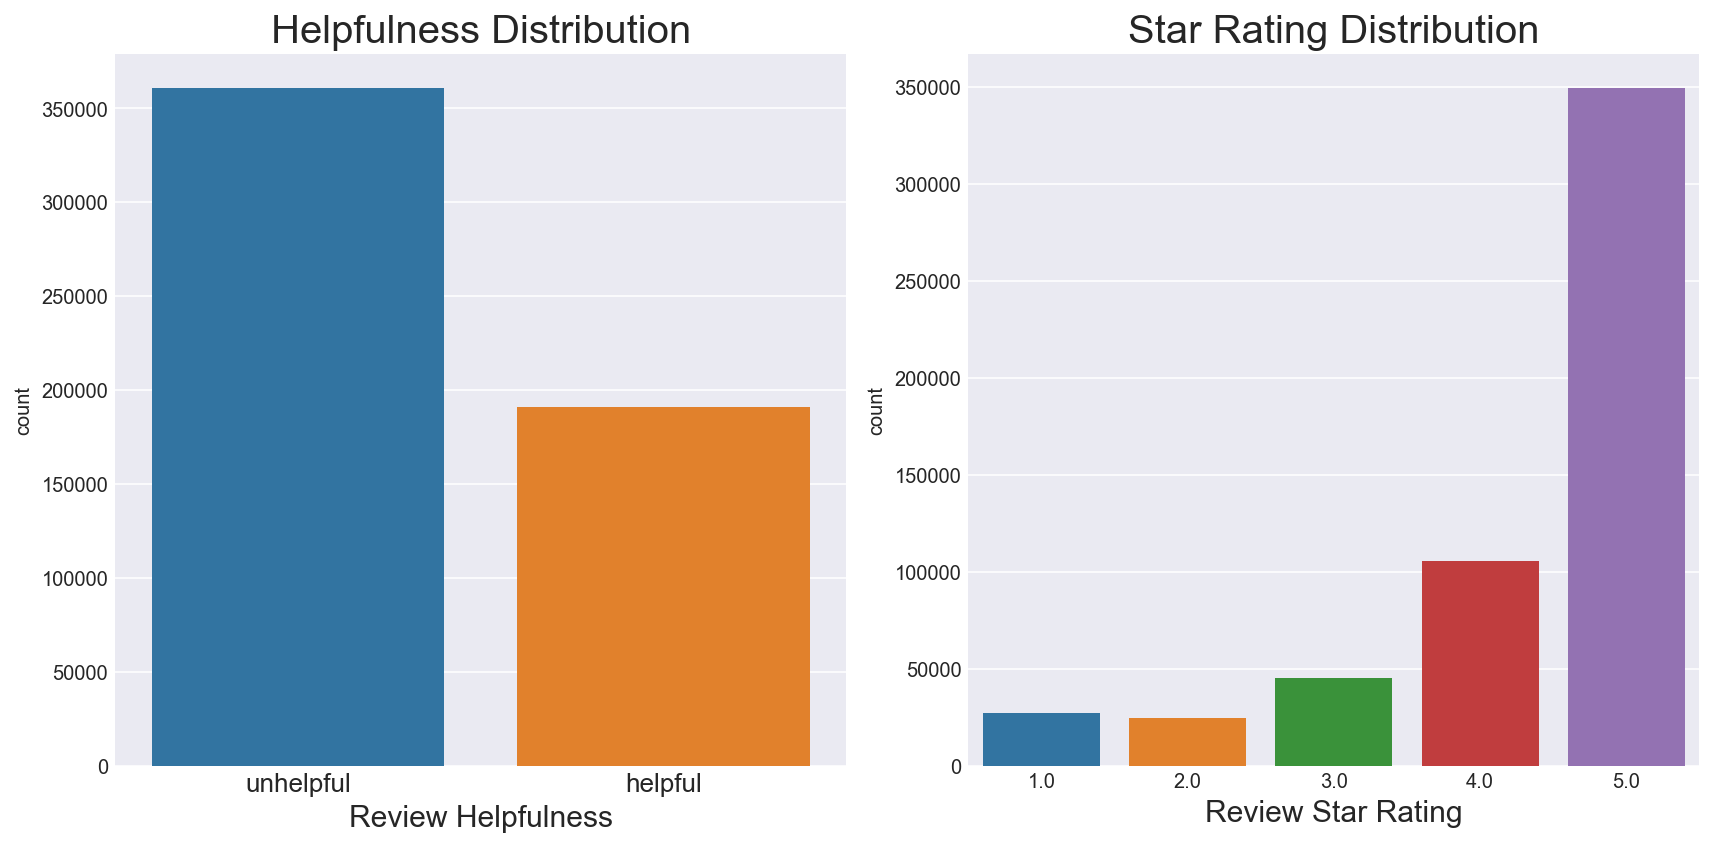

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.countplot(x=df['overall'], ax=ax2)
ax2.set_xlabel('Review Star Rating', size=15)
ax2.set_title('Star Rating Distribution', size=20)

sns.countplot(x=df['target'], ax=ax1, )
ax1.set_xticklabels(labels=['unhelpful', 'helpful'], size=13)
ax1.set_xlabel('Review Helpfulness', size=15)
ax1.set_title('Helpfulness Distribution', size=20)

fig.tight_layout();

plt.savefig('Images/help_star_count.png')

##### Creating new votes_df dataframe, which drops all rows where there are no votes for 'helpful' column.

In [19]:
votes_df = df.copy()

votes_df.drop(votes_df[votes_df['total_votes']== 0].index, inplace=True)

# Resetting index after dropping rows
votes_df.reset_index(drop=True, inplace=True)

print(votes_df.shape)

(248634, 11)


In [20]:
print(votes_df['target'].value_counts(normalize=True).sort_index())
print('')
print(votes_df['overall'].value_counts(normalize=True).sort_index())

0    0.232937
1    0.767063
Name: target, dtype: float64

1.0    0.080701
2.0    0.060076
3.0    0.098020
4.0    0.192399
5.0    0.568804
Name: overall, dtype: float64


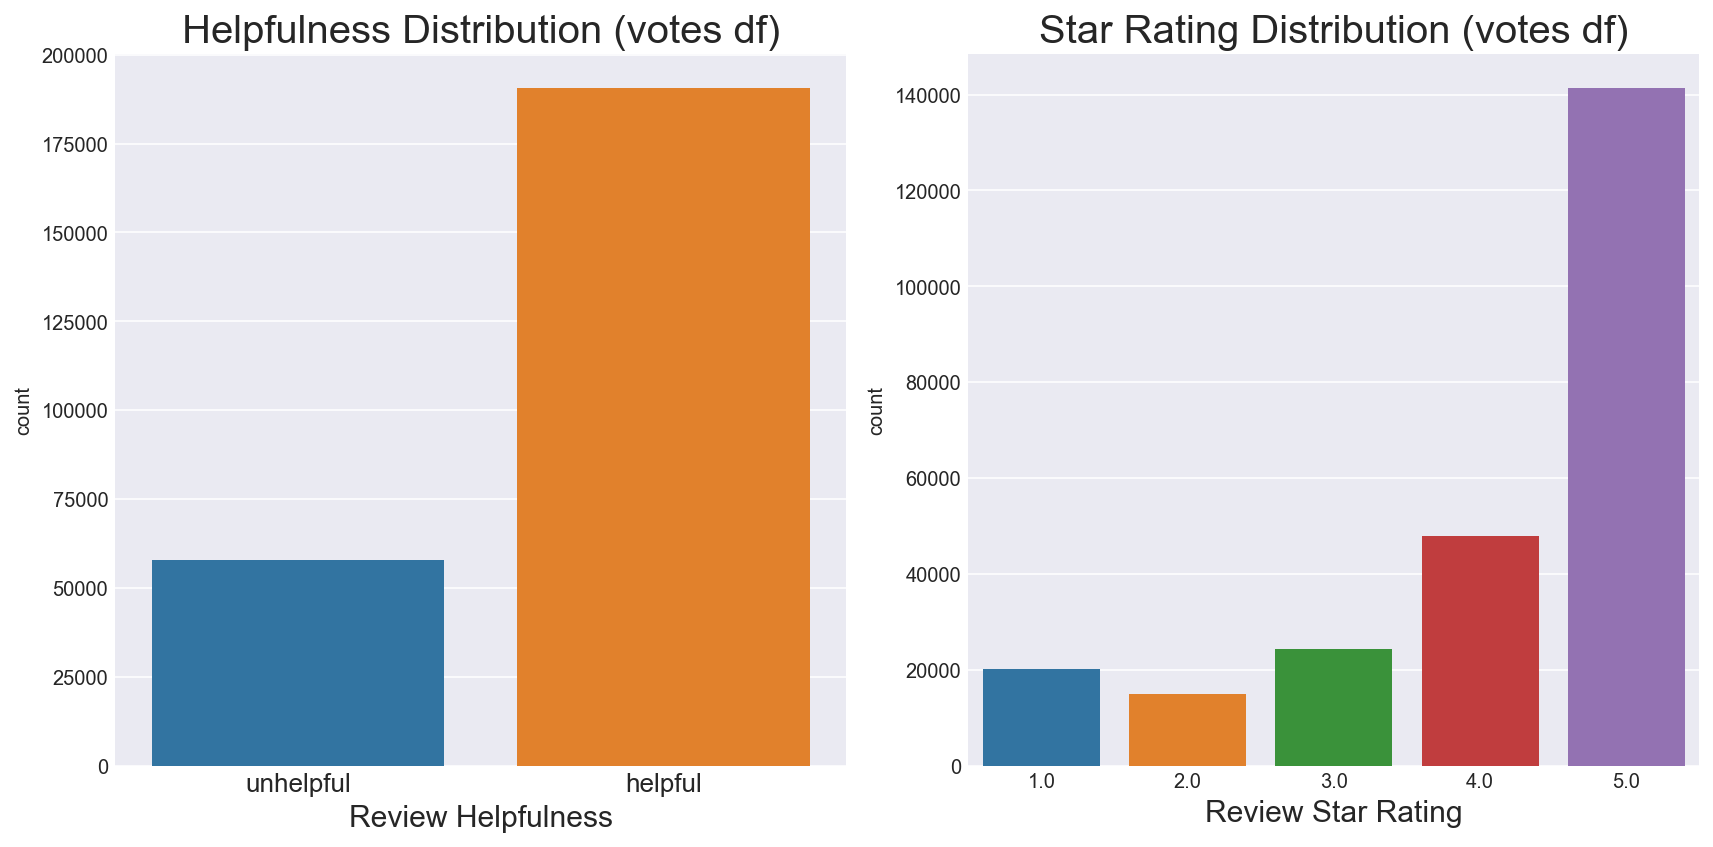

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.countplot(x=votes_df['overall'], ax=ax2)
ax2.set_xlabel('Review Star Rating', size=15)
ax2.set_title('Star Rating Distribution (votes df)', size=20)

sns.countplot(x=votes_df['target'], ax=ax1, )
ax1.set_xticklabels(labels=['unhelpful', 'helpful'], size=13)
ax1.set_xlabel('Review Helpfulness', size=15)
ax1.set_title('Helpfulness Distribution (votes df)', size=20)

fig.tight_layout();

plt.savefig('Images/help_star_count_votesdf.png')

In [22]:
pd.DataFrame(df.groupby(by=['overall'])['target'].value_counts(normalize=True))

target
overall target          
1.0     0       0.572567
        1       0.427433
2.0     0       0.636614
        1       0.363386
3.0     0       0.653366
        1       0.346634
4.0     0       0.645667
        1       0.354333
5.0     0       0.664586
        1       0.335414

In [23]:
pd.DataFrame(votes_df.groupby(by=['overall'])['target'].value_counts(normalize=True).sort_index())

target
overall target          
1.0     0       0.422577
        1       0.577423
2.0     0       0.408516
        1       0.591484
3.0     0       0.359115
        1       0.640885
4.0     0       0.218492
        1       0.781508
5.0     0       0.170629
        1       0.829371

Distribution of star ratings between original df and votes_df are farily similar, however the target variable proportions have flipped. The unhelpful variable in votes_df is now the minority class, after getting rid of all the data points that had no helpful/unhelpful votes.

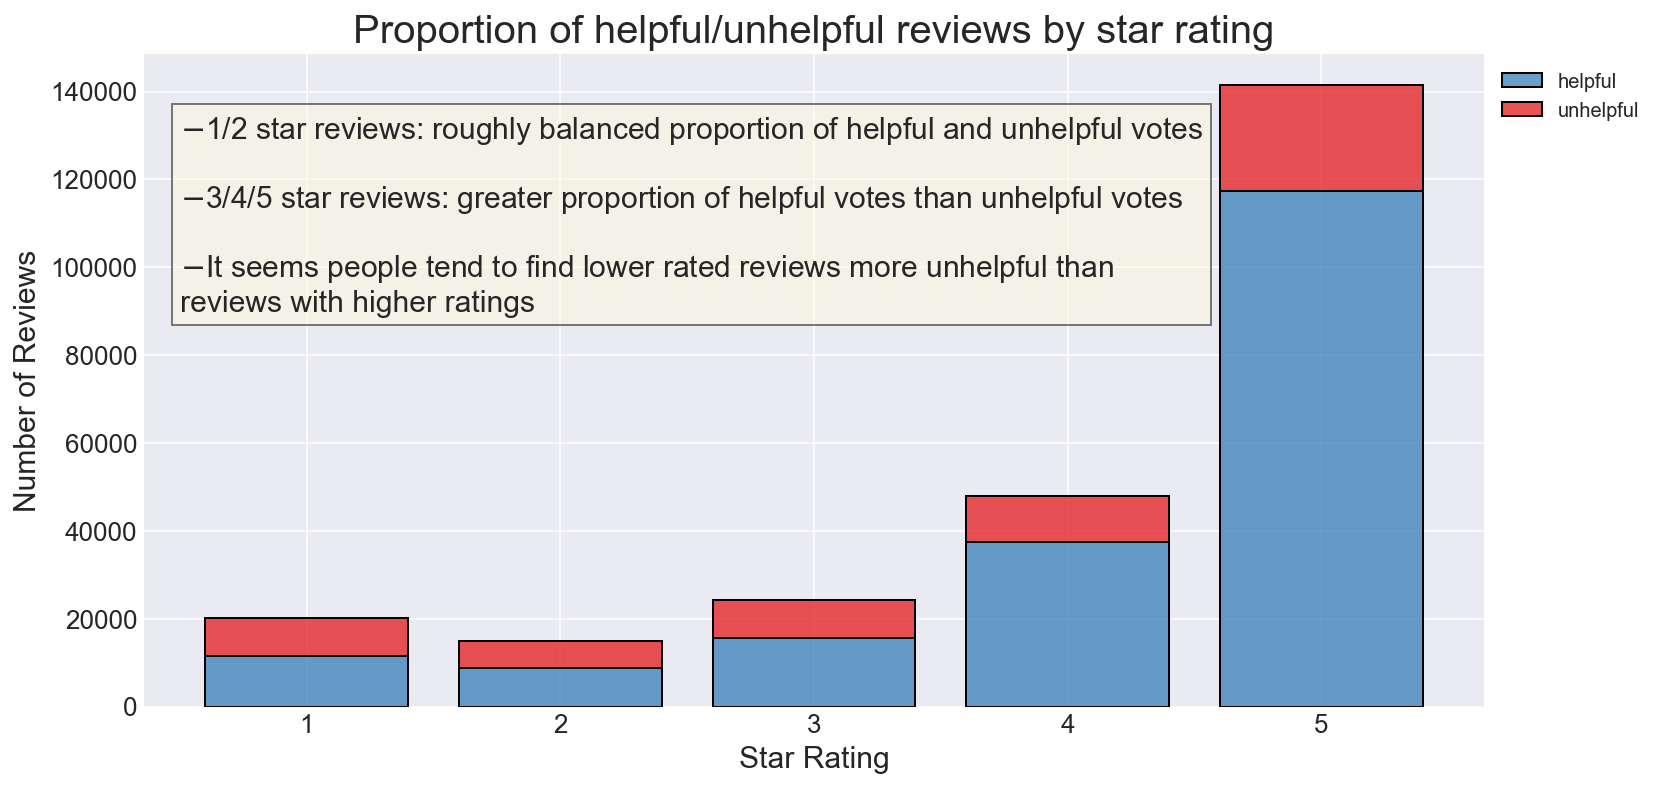

In [24]:
plt.figure(figsize=(12,6))
sns.histplot(data=votes_df, x='overall', stat='count', hue='target',
             multiple='stack', palette='Set1', discrete=True, shrink=.8) #palette='husl', multiple='dodge', 'FILL'

plt.title('Proportion of helpful/unhelpful reviews by star rating', size=20)
plt.xticks(ticks=votes_df['overall'].unique(), size=13)
plt.yticks(size=13)
plt.ylabel('Number of Reviews', size=15)
plt.xlabel('Star Rating', size=15)

plt.text(0.5, 90_000,
         '$-$1/2 star reviews: roughly balanced proportion of helpful and unhelpful votes\n\n$-$3/4/5 star reviews: greater proportion of helpful votes than unhelpful votes\n\n$-$It seems people tend to find lower rated reviews more unhelpful than\nreviews with higher ratings',
         fontsize=15, 
         bbox = dict(facecolor='cornsilk', alpha=0.5)
        )

plt.legend(labels=(['helpful', 'unhelpful']), loc='upper left', bbox_to_anchor=(1,1), ncol=1);

plt.savefig('Images/help_by_star_rating.png')

##### Creating reviewText word count column

In [25]:
def word_count(review):
    return len(review.split())

votes_df['review_word_count'] = votes_df['reviewText'].map(word_count)

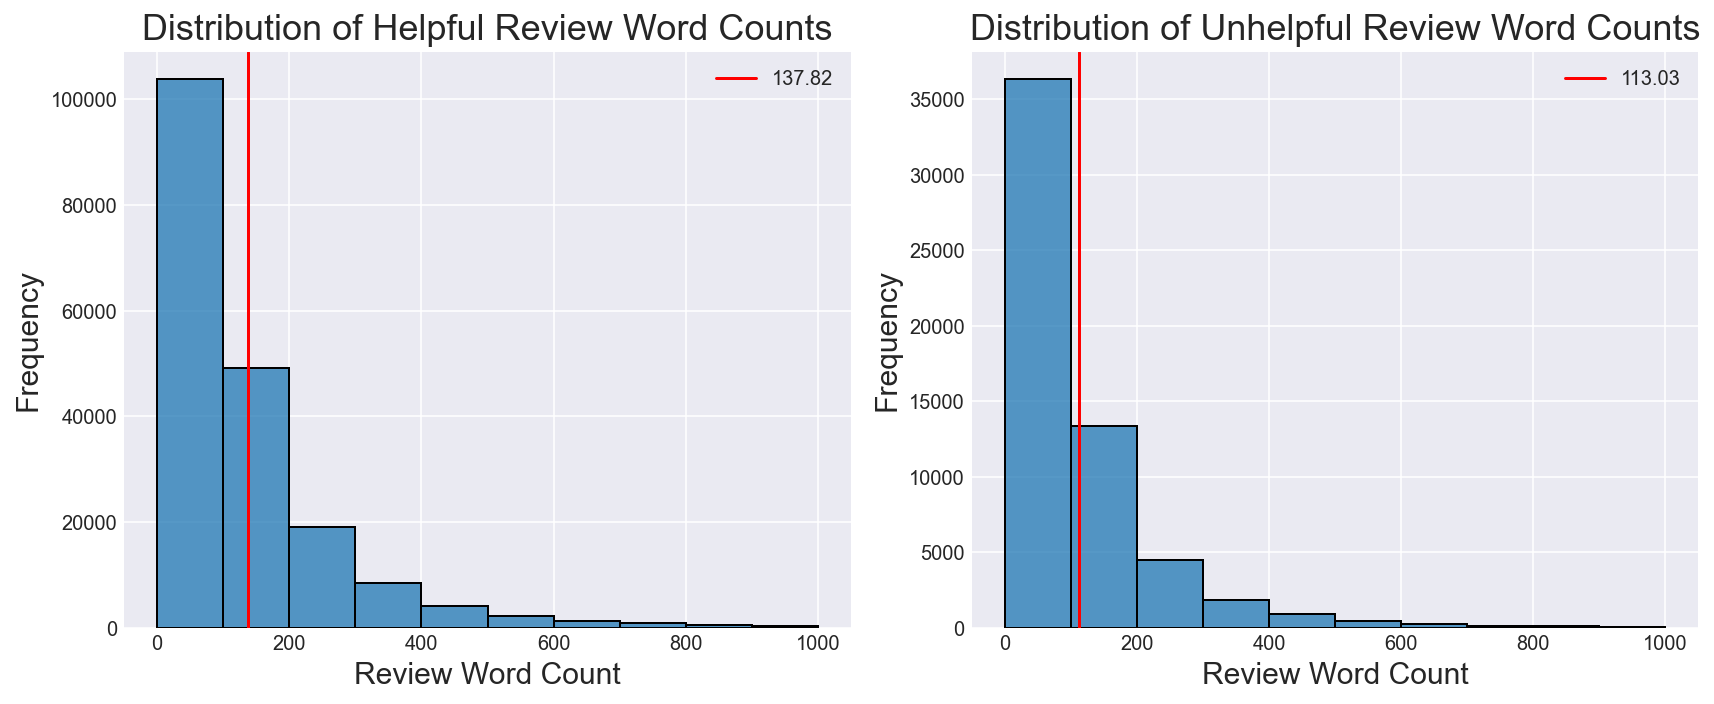

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Left plot
sns.histplot(votes_df[votes_df['target'] == 1]['review_word_count'],
         bins=[0,100,200,300,400,500,600,700,800,900,1000],
        ax=ax1)
ax1.axvline(votes_df[votes_df['target'] == 1]['review_word_count'].mean(), color='red',
           label=str(np.round(votes_df[votes_df['target'] == 1]['review_word_count'].mean(),
                             decimals=2)))
ax1.set_title('Distribution of Helpful Review Word Counts', size=18)
ax1.set_xlabel('Review Word Count', size=15)
ax1.set_ylabel('Frequency', size=15)
ax1.legend()

# Right plot
sns.histplot(votes_df[votes_df['target'] == 0]['review_word_count'],
         bins=[0,100,200,300,400,500,600,700,800,900,1000],
        ax=ax2)
ax2.axvline(votes_df[votes_df['target'] == 0]['review_word_count'].mean(), color='red',
           label=str(np.round(votes_df[votes_df['target'] == 0]['review_word_count'].mean(),
                             decimals=2)))
ax2.set_title('Distribution of Unhelpful Review Word Counts', size=18)
ax2.set_xlabel('Review Word Count', size=15)
ax2.set_ylabel('Frequency', size=15)
ax2.legend()

fig.tight_layout();

plt.savefig('Images/help_word_counts.png')

Helpful reviews are a little more wordy than unhelpful reviews on average. The average number of words in a helpful review is 137.82, compared to an average of 113.03 words in an unhelpful review.

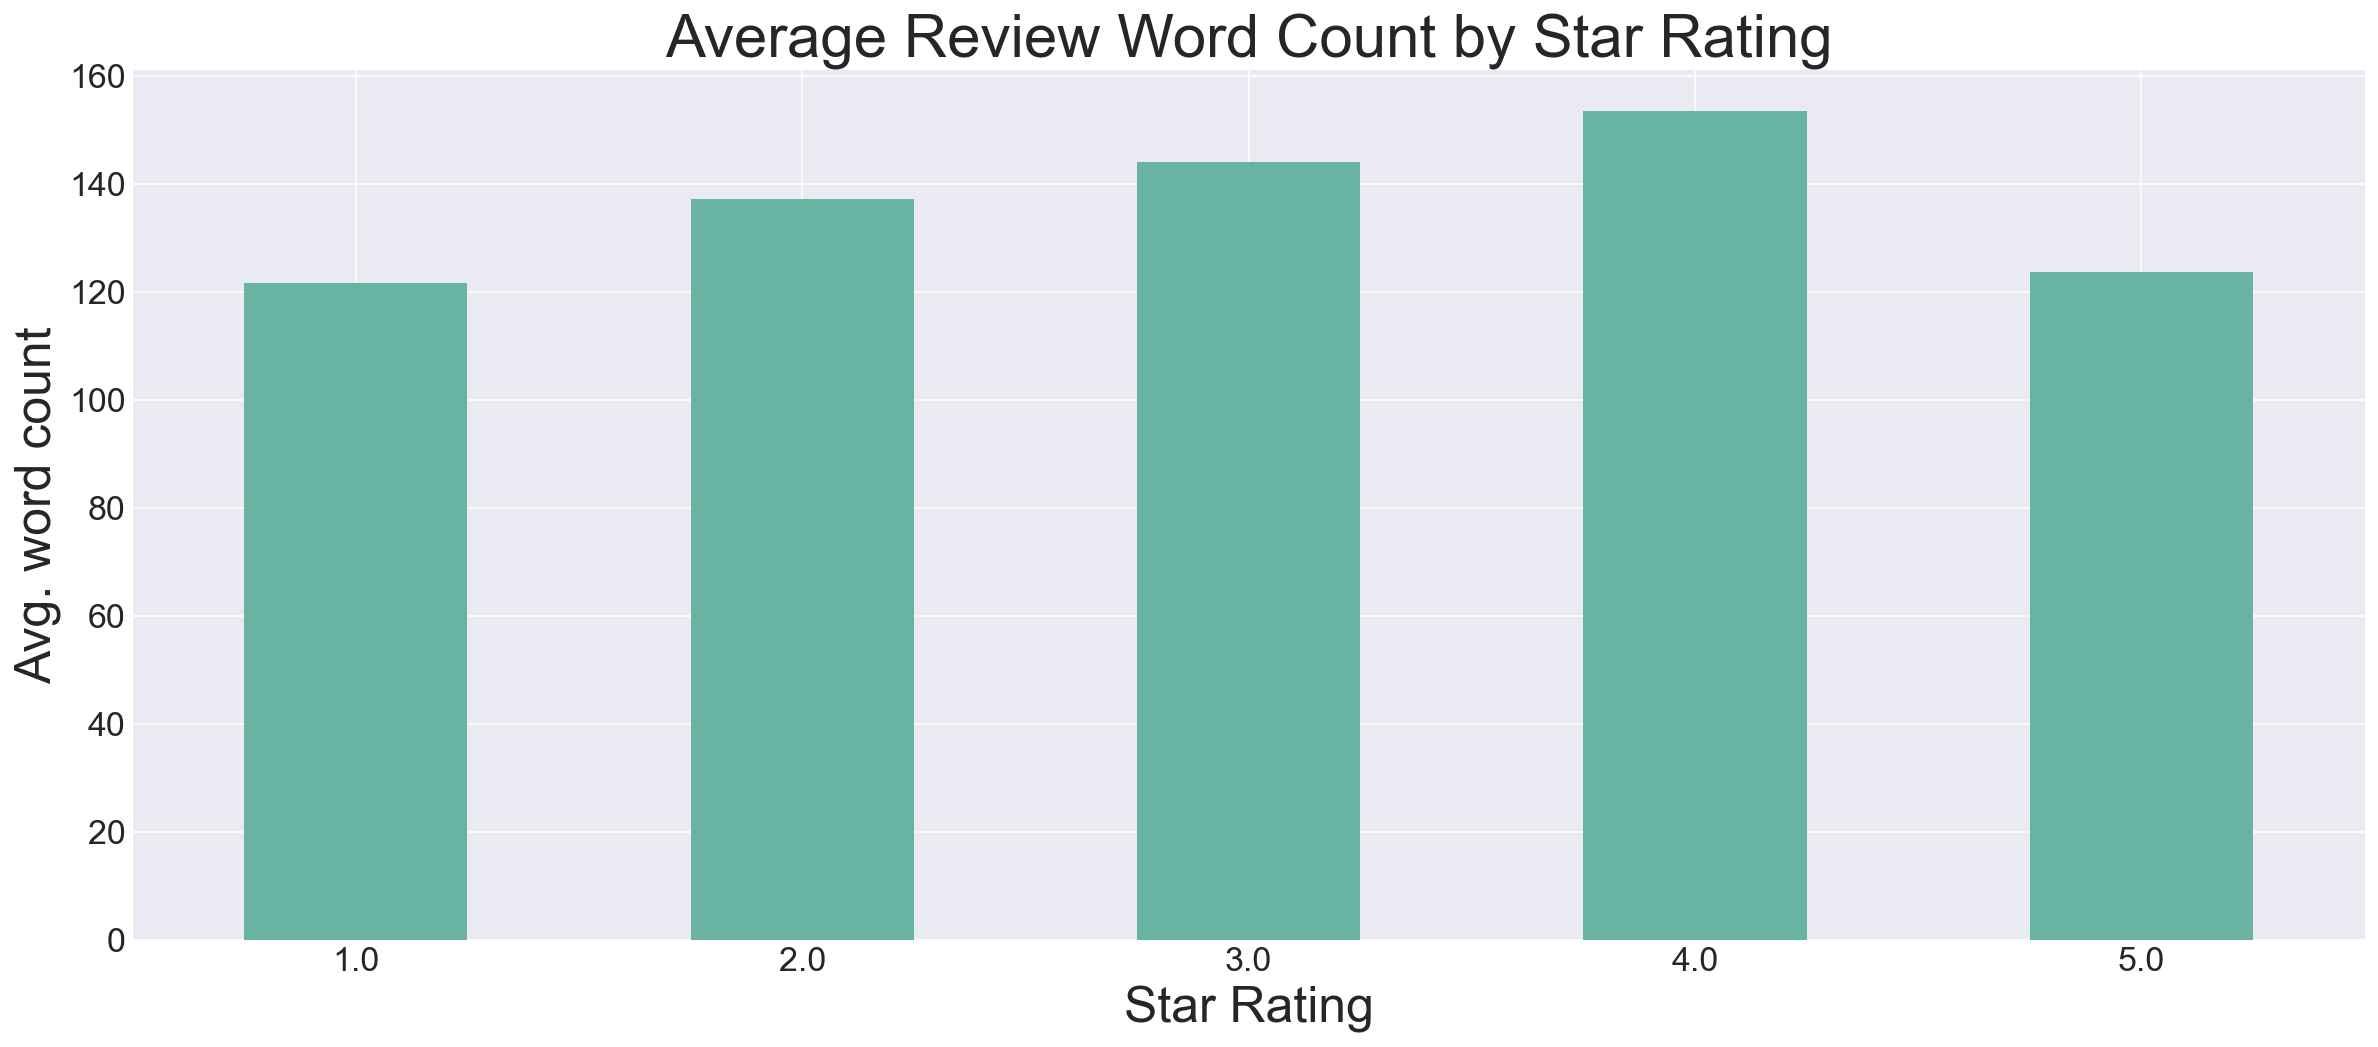

In [27]:
plt.figure(figsize=(20, 8))
votes_df.groupby('overall').mean()['review_word_count'].plot(kind='bar', color='#69b3a2')

plt.title('Average Review Word Count by Star Rating', size=30)
plt.xticks(rotation=360, size=17)
plt.yticks(size=17)
plt.ylabel('Avg. word count', size=25)
plt.xlabel('Star Rating', size=25);

plt.savefig('Images/word_count_star.png')

1 and 5 star reviews are on the lower end of the average word count, hovering just above 120 words per review.  
2, 3, and 4 star reviews all average above 130 words per review, with 4 star reviews having the highest average word count at a little over 150 words per review.

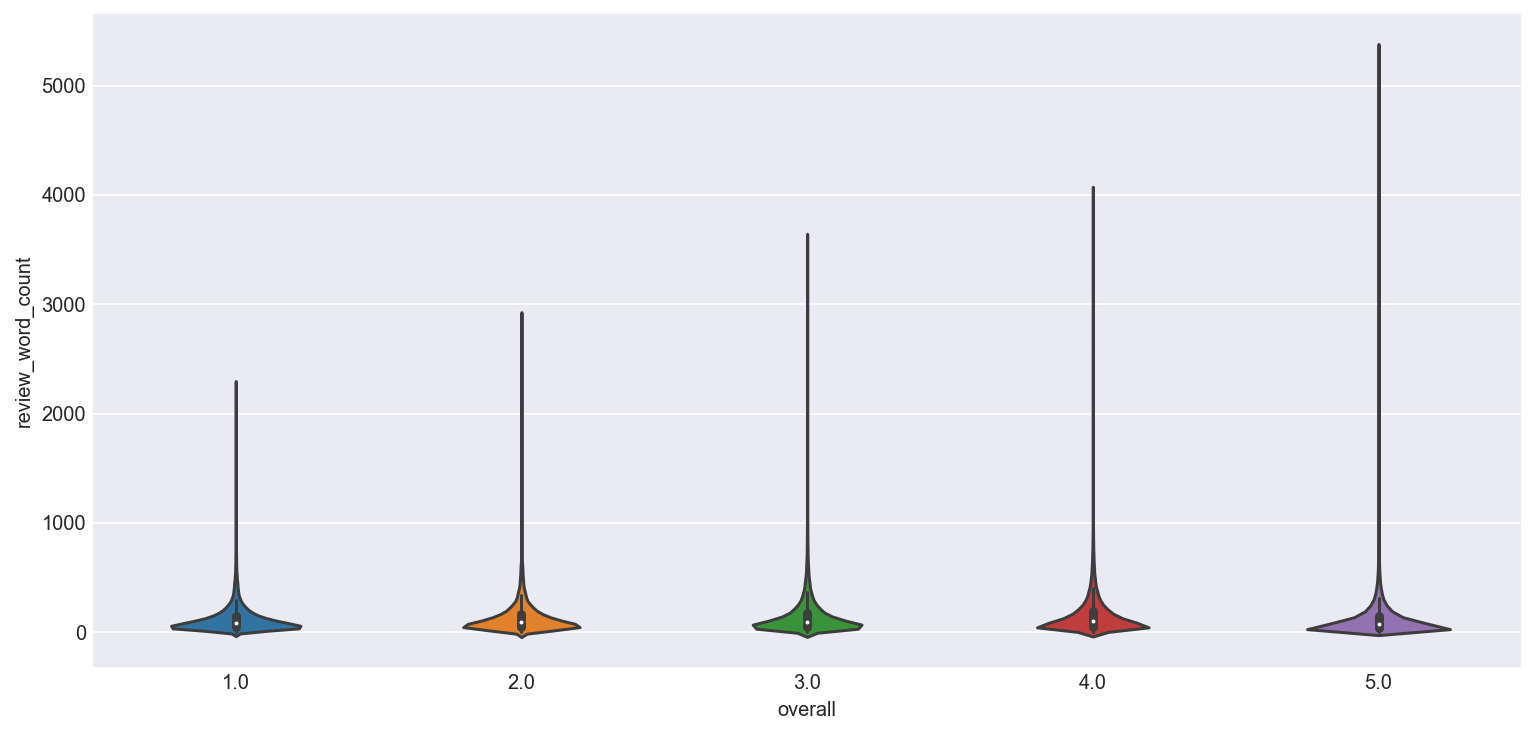

In [29]:
plt.figure(figsize=(12.8,6))
sns.violinplot(data=votes_df, x='overall', y='review_word_count', width=.5,);

plt.savefig('Images/word_count_star_spread.png')

the number of high average word count reviews belonging to each star rating class, tends to increase as star rating increases.

##### Dropping 164 rows where 'reviewText' is empty

In [32]:
votes_df.drop(votes_df[votes_df['review_word_count'] == 0].index, inplace=True)

# Resetting index after dropping rows
votes_df.reset_index(drop=True, inplace=True)

print(votes_df.shape)

(248440, 12)


##### Trends within Review Text

In [34]:
votes_df['reviewText'].iloc[248070]

'Great product, easy to use and clean. Great bonused with product, excellent!'

In [35]:
votes_df['reviewText'].iloc[243309]

'I can always use another cooling rack since I do a lot of baking; however, this "premium" rack falls short, despite some advantages, when compared to my others.First, the good:  it has a non-stick surface that makes it easier to remove moister baked items such as cakes.  The grid pattern, something that none of my others use, helps a lot with smaller items such as cookies that can slip between bars if not placed perfectly flat.  I can place a cookie at a slight angle on this rack, and I don\'t have to worry about bending an edge.  While the size, at roughly 10" x 18", isn\'t big enough for lots of cookies, it will handle two 9" cake layers, albeit it closely.  My rack arrived with everything firmly welded in place.And the not-so-good:  I am annoyed that the rack is not really dishwasher-safe.  I find that racks are both difficult to clean and difficult to rinse, so I always place my racks in the dishwasher for more thorough cleaning.  Even though the instructions say you CAN put it in

##### Most helpful 1-star review

In [36]:
votes_df[(votes_df['total_votes'] > 50) & (votes_df['overall'] < 3)].sort_values(by=['total_votes', 'ratio'], ascending=False).head(3)

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target,review_word_count
96702,A17V9XL4CWTQ6G,B000RPVHZU,Chandler,(update: This review was updated on 11-2-09 af...,1.0,The steam mop SHOWDOWN: a first-hand compariso...,2009-11-02,5081,5126,0.991221,1,1881
130045,A28Q94CXRMP2SY,B001N07KUE,Eric Law,** This review has been edited ** I now give ...,2.0,Great customer service!,2009-05-19,3716,3787,0.981252,1,151
131337,A17V9XL4CWTQ6G,B001PNRRD4,Chandler,(update: This review was updated on 11-2-09 af...,2.0,The steam mop SHOW DOWN: Results of steam mop ...,2009-08-07,2777,2817,0.985800,1,1969


In [37]:
votes_df['reviewText'].iloc[96702]

'(update: This review was updated on 11-2-09 after I got to compare the Bissell as well as add notes about the Ladybugg steamer at the bottom)I live in a neighborhood where EVERY home is "green built certified" this means that, to have that certification, the builder built no homes with carpet. All the main floors are polished concrete and the upper floors wood. The bathrooms all have tile and/or slate in every home.Because of this, as you could imagine, steam mops are quite the neccessity...not only because they get the hard surfaces better than anything else, but because they are also "green" and clean chemical free. I\'ll be honest, for us...that\'s a bonus but we weren\'t cleaning chemical free before. We like chemical free for our pet\'s paws but I\'ll confess I was mopping with chemicals before I got my steamer and just kept the pets out of the room while doing it because, up until then, I couldn\'t get it clean any other way.Okay, so that said...we decided to have a steamer show

##### Most unhelpful 1-star review

In [38]:
votes_df[(votes_df['total_votes'] > 50) & (votes_df['overall'] < 3) & (votes_df['ratio'] != 0)].sort_values(by=['ratio', 'total_votes'], ascending=True).head(3)

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target,review_word_count
9097,A153UHG67W8TDM,B00004SZ7H,Moira Dennis-Decking,How can I review something that I have never o...,1.0,Say what??,2012-03-02,1,165,0.006061,0,31
133327,A12XWM9TXYUV4,B001TK2XH8,Gene T. Blakely,"ordered this item - and as often happens, a fr...",2.0,You never know until you buy.,2011-07-22,1,102,0.009804,0,70
1747,AI0NMYA3LKXW1,B00004OCMB,"Bartok Kinski ""A casual stroll through the lu...","I've always found the ""Pie Server"" utensil use...",1.0,utencil useless,2010-10-11,1,96,0.010417,0,152


In [39]:
votes_df['reviewText'].iloc[9097]

'How can I review something that I have never ordered or received.  They do look like they would be a nice set to have as I do a lot of baking.'

In [40]:
votes_df['reviewText'].iloc[133327]

'ordered this item - and as often happens, a friend got the package and mail and drove it up my 1/4 mile driveway on the tri-weekly visit. After opening the package, I ask my friend if she could use the contents. She said "yes" and so I gave the packaged contents to her.  She\'s has made no comment to the contrary, so I guess the contents were suitable to her.'

In [41]:
votes_df['reviewText'].iloc[1747]

'I\'ve always found the "Pie Server" utensil useless, especially if you don\'t have room for kitchen cabinets to store all the utensils.  You can get by just by using a fork and a regular butter knife or a turner, a flipper or spatula.That is what I tend to use.  You do have a higher Pie drop ratio with a fork and a butter knife or spatula but it won\'t matter unless you\'re in a social setting where a "Pie Server" utensil is deemed absolutely necessary.  And then, you\'ll probably be eating caviar with snob Pie anyways.  Sometimes I even use my dirty hand or just use a dirty spoon to eat Pie out of the tin.Now, I just use the Oxo SteeL Pie Server as a Masonry trowel for spreading mortar on bricks or concrete blocks with a technique called "buttering".  It isn\'t "heavy duty" but for touch up jobs, it\'s acceptable.'

The most unhelpful negative reviews seem to be reviews that don't have much to do with the features of the advertised product.

##### Most helpful 5-star review

In [42]:
votes_df[votes_df['ratio'] != 1].sort_values(by=['total_votes', 'ratio'], ascending=False).head(3)

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target,review_word_count
179853,A1TTA1UUGY4WY4,B0047E0EII,SW3K,For decades I have been trying to come up with...,5.0,"No more winning for you, Mr. Banana!",2011-03-03,52176,52861,0.987041,1,163
129605,A17V9XL4CWTQ6G,B001LYFBHG,Chandler,Note: I have updated this review in March of 2...,5.0,The top steam mops: Results of steam mop first...,2009-08-07,6128,6174,0.992549,1,3035
86449,A1IXJK1NYTSMJU,B000MDHH06,"Ed Osworth ""The Joy Professor""",I juice at least once a day as I primarily eat...,5.0,WOW - Way better than expected - XLNT daily ju...,2007-08-24,5247,5307,0.988694,1,332


In [43]:
votes_df['reviewText'].iloc[179853]

'For decades I have been trying to come up with an ideal way to slice a banana.  "Use a knife!" they say.  Well...my parole officer won\'t allow me to be around knives.  "Shoot it with a gun!"  Background check...HELLO!  I had to resort to carefully attempt to slice those bananas with my bare hands.  99.9% of the time, I would get so frustrated that I just ended up squishing the fruit in my hands and throwing it against the wall in anger. Then, after a fit of banana-induced rage, my parole officer introduced me to this kitchen marvel and my life was changed.  No longer consumed by seething anger and animosity towards thick-skinned yellow fruit, I was able to concentrate on my love of theatre and am writing a musical play about two lovers from rival gangs that just try to make it in the world.  I think I\'ll call it South Side Story.Banana slicer...thanks to you, I see greatness on the horizon.'

Interesting to note that the most helpful review is CLEARLY SARCASM!!! However, will be difficult for model to detect that when training on it.

In [44]:
votes_df['reviewText'].iloc[129605]

'Note: I have updated this review in March of 2013 comparing this mop to Eureka\'s new mop called "Two in One" I do not like Eureka\'s new steam mop model 150A as much as this one (I actually don\'t like Eureka\'s model 150 at all) but I"ve added the notes to my review as well as a few other new mops we\'ve gotten to try out. We have a second home now and I\'m in the market for a new steam mop. In trying out new ones, even the new Eureka one, I still like this old model 313A the best.Know going in If you get the Envirosteamer, know that, though it cleans the best, the first two times you use it the water goes through holes faster than it will in subsequent uses, so it will go through steam faster and your floors will be wetter than normal. Enough people wrote me to know this happened the first one or two times as it did my first time of use,  then after that the mop was normal, our floors are great  and it lasts waaaah longer. We don\'t know why.  Just know that going in.  After the fi

##### Most unhelpful 5-star review

In [45]:
votes_df[(votes_df['total_votes'] > 50) & (votes_df['overall'] > 3) & (votes_df['ratio'] >= 0)].sort_values(by=['ratio'], ascending=True).head(3)

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target,review_word_count
113587,A3C94W97NOIKPW,B0017SZT1E,Maureen C. Jamgochian,"I haven't used it yet, but looks like it would...",4.0,pizza peel,2009-05-01,0,51,0.000000,0,17
189543,A1M00SKKKSNGTF,B004T6BJ56,"S. Snow ""beccadog""",All Clad Stainless 14-Inch Open Stir Fry has n...,5.0,All Clad Stainless 14-Inch Open Stir Fry will ...,2006-08-15,1,53,0.018868,0,30
102409,AW7EBHQOX4OAV,B000VML7KO,Stefwef,My star has to do with feeling misled by Amazo...,5.0,TORCH ARRIVES EMPTY OF FUEL,2011-07-16,2,73,0.027397,0,261


In [46]:
votes_df['reviewText'].iloc[113587]

"I haven't used it yet, but looks like it would be a great asset to my kitchen."

In [47]:
votes_df['reviewText'].iloc[189543]

'All Clad Stainless 14-Inch Open Stir Fry has not been used as yet.  It will be a wedding present for our daughter.  Feedback can be given after September 2, 2006.'

In [48]:
votes_df['reviewText'].iloc[102409]

'My star has to do with feeling misled by Amazon about how this torch would arrive without any fuel in it / I cannot comment on actual torch operations since I have yet to get fuel.After a long wait to receive the microtorch, which I intend to try out for jewelry-making, I finally got to open the box which arrived undamaged. Turn the knob "open" and "click" to ignite - nothing happens. Then I see in small print on the box "Enclosed does not contain fuel." Please be aware: you will need to buy your first (and subsequent of course) can of gas and fill the torch before your first use. Hence, initially this is really a "fillable" microtorch, not a refillable one. I felt very misled by Amazon in this regard, as to me "[refillable] torch operates with a standard butane canister (sold separately)" is not synonymous with "torch sold does not contain fuel." It seems very simple for them to add clarity to their listing, but the answer I got back from customer service confirms that the current li

Most unhelpful 4/5-star reviews also seem to have a trend of the reviews not having much to do with the featues of the advertised product.

##### Saving votes_df dataset

In [49]:
votes_df.to_csv('Data/reviews.csv', index=False)